In [14]:
%matplotlib inline

## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available at [NeuroVault (2071)](http://neurovault.org/collections/2071/).


In [15]:
import os
from subprocess import check_call
import zipfile
import json
from urllib2 import urlopen, URLError, HTTPError
from urllib2 import Request
from nilearn import plotting

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection ZJNRUHIM and UMMSIQGP
 - Download and save the packs in sub-folder `input/data` 

In [16]:
nv_collections = (
    '2071',
)

for nv_collection in nv_collections:
    request = Request('http://neurovault.org/api/collections/' + nv_collection + '/nidm_results/?limit=184&format=json')
    response = urlopen(request)
    elevations = response.read()
    data = json.loads(elevations)

    pwd = os.path.dirname(os.path.realpath('__file__'))
    input_dir = os.path.join(pwd, "input")
    data_dir = os.path.join(input_dir, "data")

    if not os.path.isdir(data_dir):
        if not os.path.isdir(input_dir):
            os.makedirs(input_dir)
        os.makedirs(data_dir)


    for nidm_result in data["results"]:
        url = nidm_result["zip_file"]
        study_name = nidm_result["name"]

        localzip = os.path.join(data_dir, study_name + ".zip")
        localzip_rel = localzip.replace(pwd, '.')
        if not os.path.isfile(localzip):
            # Copy .nidm.zip export locally in a the data directory
            try:
                f = urlopen(url)
                print("downloading " + url + " at " + localzip_rel)
                with open(localzip, "wb") as local_file:
                    local_file.write(f.read())
            except HTTPError, e:
                raise Exception(["HTTP Error:" + e.code + url])
            except URLError, e:
                raise Exception(["URL Error:" + e.reason + url])
        else:
            print(url + " already downloaded at " + localzip_rel)

http://neurovault.org/collections/2071/spm_0001.nidm.zip already downloaded at ./input/data/spm_0001.nidm.zip
http://neurovault.org/collections/2071/spm_0002.nidm.zip already downloaded at ./input/data/spm_0002.nidm.zip
http://neurovault.org/collections/2071/fsl.nidm.zip already downloaded at ./input/data/fsl.nidm.zip


In [19]:
import zipfile
import shutil

# *** SPM group activations
spm_pack = open('./input/data/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/data/')
z.extract('Mask.nii.gz', './input/data/')

# Thresholded statistics
spm_exc_set_file = './input/data/spm_exc_set.nii.gz'
shutil.move('./input/data/ExcursionSet.nii.gz', spm_exc_set_file)

# Analysis mask
spm_mask_file = './input/data/spm_mask.nii.gz'
shutil.move('./input/data/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/data/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/data/')

# Thresholded statistics
spm_exc_set_file_neg = './input/data/spm_exc_set_neg.nii.gz'
shutil.move('./input/data/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/data/fsl.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/data/')
z.extract('ExcursionSet_T002.nii.gz', './input/data/')
z.extract('Mask.nii.gz', './input/data/')

# Thresholded statistics
fsl_exc_set_file = './input/data/fsl_exc_set.nii.gz'
shutil.move('./input/data/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/data/fsl_exc_set_neg.nii.gz'
shutil.move('./input/data/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Analysis mask
fsl_mask_file = './input/data/fsl_mask.nii.gz'
shutil.move('./input/data/Mask.nii.gz', fsl_mask_file)

exc_sets = dict()
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg))
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg))

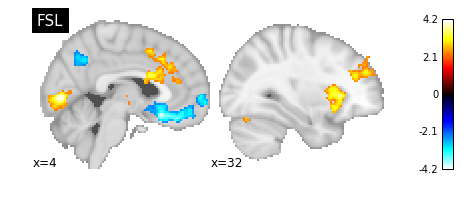

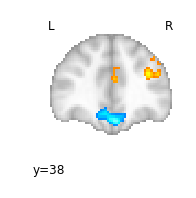

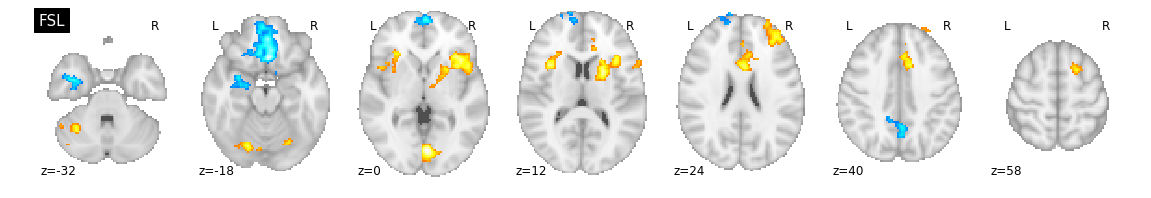

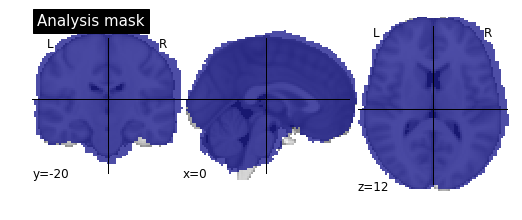

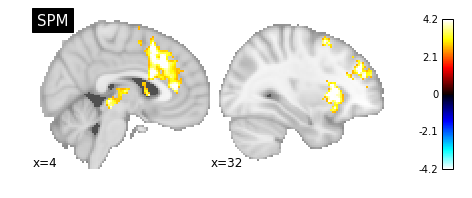

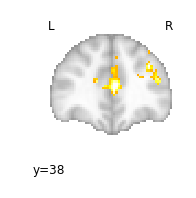

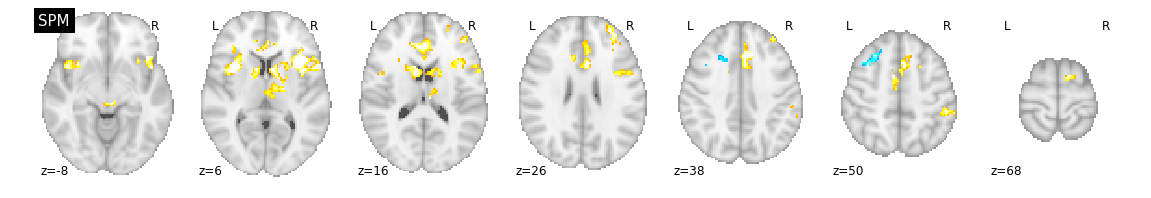

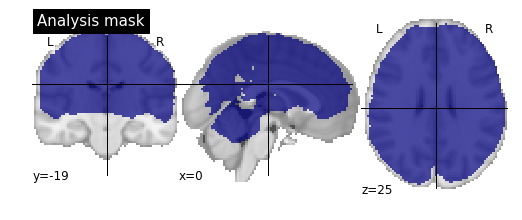

In [21]:
from nilearn import plotting
from nilearn.image import math_img
import numpy as np
from nilearn.masking import apply_mask
from nilearn.image import load_img, new_img_like
from nilearn._utils.niimg_conversions import _safe_get_data
import nibabel as nib


for soft, (mask_file, (exc_set_file, exc_set_file_neg)) in exc_sets.items():
    # Remove NaNs
    n = nib.load(exc_set_file)
    d = n.get_data()
    exc_set_nonan = nib.Nifti1Image(np.nan_to_num(d), n.affine, header=n.header)
    
    n = nib.load(exc_set_file_neg)
    d = n.get_data()
    exc_set_neg_nonan = nib.Nifti1Image(np.nan_to_num(d), n.affine, header=n.header)
    
    # Combine activations and deactivations in a single image 
    to_display = math_img("img1-img2", img1=exc_set_nonan, img2=exc_set_neg_nonan)

    # Display x=4, y=32 and y=38 as in the manuscript
    display = plotting.plot_stat_map(to_display, display_mode='x', cut_coords=[4, 32], draw_cross=False, colorbar=True, 
                           title=soft.upper(), threshold=0.000001, vmax=4.2)
    display = plotting.plot_stat_map(to_display, cut_coords=[38], draw_cross=False, display_mode='y', 
                           threshold=0.000001, colorbar=False, vmax=4.2)
    # Additional plot: slices along z
    display = plotting.plot_stat_map(to_display, cut_coords=7, draw_cross=False, display_mode='z', 
                           threshold=0.000001, colorbar=False, vmax=4.2, title=soft.upper())
    # Analysis mask
    display = plotting.plot_roi(mask_file, title='Analysis mask')



plotting.show()